# CS 121 Lecture 4 : Defining computation

In [96]:
%%html
<style>
.rise-enabled .cell .input_prompt {
    display: none;
}
</style>
<!--- <style>

.CodeMirror {
    width: 100vw;
}
S
.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}

td {
  font-size: 50px
}
</style> -->

# Utilities

In [ ]:
import schemdraw
import schemdraw.logic as logic
import schemdraw.elements as elm

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
class Bit:
    """A class representing a logical bit. 
       Keeps track of operations that are done to it"""
 
    def __init__(self, program):
        self.program = program if isinstance(program,tuple) else (program,)
  
    def op(self,oper, other = None):
        if other is None:
            return Bit((oper,self.program))
        return Bit((oper,self.program,other.program))
        
    def __and__(self,other): return self.op("∧", other)
    def __or__(self,other): return self.op("∨", other)
    def __invert__(self): return self.op("¬")
    
    def __repr__(self): return f"Bit({self.program})" 

def NAND(a,b):
    if isinstance(a,Bit) and isinstance(b,Bit):
        return a.op("N",b)
    return ~(a&b)

In [ ]:
def AND(a,b): return a & b

def OR(a,b): return a | b

def NOT(a): return ~ a

In [ ]:
a = Bit("a")
b = Bit("b")
c = a & b
print(a)
print(b)
print(c)

In [ ]:
def bits(n):
    return [Bit(f"X[{i}]") for i in range(n)]

In [ ]:
def p2f(P):
  """Recursive function to transform a program of a Bit into a formula"""
  if len(P)==1:
    return P[0]
  if len(P)==2:
    return P[0] + p2f(P[1])
  if len(P)==3:
    return f"({p2f(P[1])} {P[0]} {p2f(P[2])})"
  return f"{P[0]}("+",".join([p2f(P[i]) for i in range(1,len(P))])+")"



In [ ]:
counter = 0
def AON_(P):
    """Recursive function to transform a program of a bit into an AON straightline program"""
    def uid():
        global counter
        counter +=1
        return f"z_{counter}"
    funcs = {"∧": "AND", "∨": "OR", "¬": "NOT", "N":"NAND" }
    if len(P)==1:
        return "",P[0]
    op = funcs[P[0]]  
    if len(P)==2:
        prog, out_ = AON_(P[1])
        out = uid() 
        return prog+f"{out} = {op}({out_})\n", out
    if len(P)==3:
        prog1,out1 = AON_(P[1])
        prog2,out2 = AON_(P[2])
        out = uid()
        return prog1+prog2+f"{out} = {op}({out1},{out2})\n", out

In [ ]:
def AON(f):
    """Take either a function or a bit and return the AON program"""
    global counter
    counter = 0
    if isinstance(f,Bit):
        P = f.program
    else:
        n = len(signature(f).parameters)
        P = f(*bits(n)).program
    prog, out = AON_(P)
    return prog.replace(out,"Y[0]")

In [ ]:
def formula(f):
    """Take either a function or a bit and return the AON program"""
    if isinstance(f,Bit):
        return Math(p2f(f.program))
    n = len(signature(f).parameters)
    F = p2f(f(*bits(n)).program)
    return Math(F)

In [ ]:
def circuit_(P, d : schemdraw.Drawing , dx=0, dy=0, drawn = {}):
  """Recursive function to draw a circuit. Gets the Bit bit and outputs the circuit used to compute it"""
  if P in drawn:
    return drawn[P]
  maxx = dx
  maxy = dy
  outs = []
  gates = { "∧" : logic.And, "∨" : logic.Or, "¬": logic.Not, "N": logic.Nand } 
  for c in P[1:]:
    dx_ , dy_ , out = circuit_(c,d,dx,dy ,drawn)
    outs.append(out)
    maxx = max(dx_,maxx)
    maxy = max(dy_,maxy)
    dy = dy_ + 1
  maxx += 2
  x,y = maxx,maxy
  gate = gates[P[0]] if P[0] in gates else logic.Dot
  g = gate(at = (x,y))
  if isinstance(g, logic.Dot):
    g.label(f"{P[0]}")
  d += g
  for i,out in enumerate(outs):
    loc = getattr(g,f"in{i+1}") 
    d += logic.Wire().at(out).to(loc)  
  drawn[P] =  x,y, g.out if hasattr(g,"out") else (x,y)
  return drawn[P]

def draw_circ(*Ys):
  drawn = {}
  dx,dy = 0,0
  with schemdraw.Drawing() as d:
    d.config(unit=0.5)
    for i,y in enumerate(Ys):
      label= f"$Y[{i}]$"
      x,dy_, out = circuit_(y.program,d,dx,dy, drawn)
      d += logic.Dot().at(out).label(label)
      dy = dy_+2


In [ ]:
def circuit(f,n=None):
    """Take a function or a bit and output circuit"""
    if isinstance(f,Bit):
        res = f
    else:
        if n is None:
            n = len(signature(f).parameters)
        res = f(*bits(n))
    return draw_circ(*res) if isinstance(res,(tuple,list)) else draw_circ(res)

In [ ]:
import re
def parse(P):
    """Take an AON program and split each line into components"""
    result  = []
    for line in P.split('\n'):
        split = re.split("=|\(|\)|,| ",line) 
        split = [x for x in split if x != ""]
        if split:
            result.append(split)
    return result
 

In [ ]:
def evalp(tuples,x, debug=True):
    """Evaluate a parsed program on an input"""
    variables = { f"X[{i}]":x[i] for i in range(len(x)) }
    for rhs,op,*oper in tuples:
        if debug: print(f"Evaluating {rhs} = {op}({','.join(oper)}):\t variables = {variables}")
        oper = [variables[o] for o in oper]
        variables[rhs] = globals()[op](*oper)
    return variables["Y[0]"]

In [ ]:
def EVAL(P,x, debug=True): 
    """Evaluate an AON-CIRC program on an input x"""
    return evalp(parse(P),x, debug)

In [ ]:
def nparams(P): 
    """Returns number of parameters of an AON-CIRC program P"""
    for i in range(len(P)+1):
        if f'X[{i}]' not in P: return i
def FUNC(P):
    """Returns the function that AON-CIRC program P computes"""
    # hack to get signature for small # of params
    n = nparams(P)
    if n == 1:
        def prog(a): return EVAL(P,[a],debug=False)
    elif n ==2:
        def prog(a,b): return EVAL(P,[a,b],debug=False)
    elif n ==3:
        def prog(a,b,c): return EVAL(P,[a,b,c],debug=False)
    else:
        def prog(*x): return EVAL(P,x,debug=False)
    return prog

In [ ]:
import itertools
from IPython.display import Markdown, display, Math
from inspect import signature

def table(f,n=None):
  """Generate truth table of a function"""
  if n is None:
    n = len(signature(f).parameters)
  m = max(n+2,len(f.__name__)+4)
  res = "x".ljust(m) + " | " + f"{f.__name__}(x)".ljust(m) 
  res += "\n" + "-"*m+"-|-"+ "-"*m 
  
  for x in itertools.product([0,1],repeat=n):
    s = "".join([str(c) for c in x])
    res += "\n"+ s.ljust(m) + " | " + str(f(*x)).ljust(m)
  res +="\n"
  return Markdown(res)

# Lecture

__Q:__ Compute $f:\{0,1\}^3 \rightarrow \{0,1\}$ s.t.
$$f(a,b,c) = \begin{cases}1 & a+b+c\geq 2 \\ 0 & \text{otherwise} \end{cases}$$
using $AND$, $OR$, and $NOT$

__Solution:__    $f(a,b,c) = (a \wedge b) \vee (b \wedge c) \vee (a \wedge c)$

In [97]:
# (a ∧ b) ∨ (b ∧ c) ∨ (a ∧ c)
def f(a,b,c): return (a & b) | (b & c) | (a & c)

In [98]:
table(f)

x     | f(x) 
------|------
000   | 0    
001   | 0    
010   | 0    
011   | 1    
100   | 0    
101   | 1    
110   | 1    
111   | 1    


In [99]:
formula(f)

<IPython.core.display.Math object>

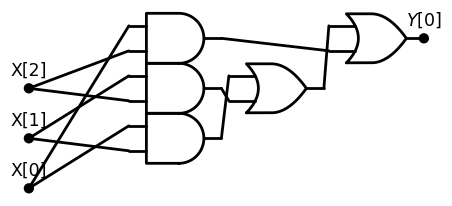

In [100]:
circuit(f)

In [101]:
print(AON(f))

z_1 = AND(X[0],X[1])
z_2 = AND(X[1],X[2])
z_3 = OR(z_1,z_2)
z_4 = AND(X[0],X[2])
Y[0] = OR(z_3,z_4)



__Q:__ Come up with a Boolean circuit that computes $XOR:\{0,1\}^2 \rightarrow \{0,1\}$ where $XOR(a,b) = a+b \mod 2$

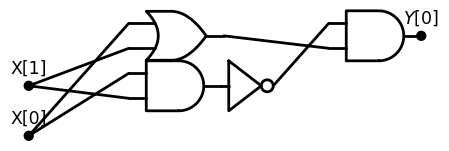

In [102]:
def f(a,b):
    c = a & b
    d = ~c
    e = a | b
    return d & e
circuit(f)

In [103]:
table(f)

x     | f(x) 
------|------
00    | 0    
01    | 1    
10    | 1    
11    | 0    


__Def I (3.5):__ <font color="red">_Boolean Circuit_</font> $C$ is a DAG where vertices  
are <font color="blue">_inputs_</font> labeled   `X[0]` ... `X[n-1]` or <font color="blue">_gates_</font>
labeled  $\wedge$/$\vee$/$\neg$.
<font color="blue">_Output gates_</font> are additionally labeled with  `Y[0]` ... `Y[m-1]`.<br>
For $x\in \{0,1\}^n$,  we denote the output of $C$ on input $x$ by $C(x)$.

__Def II (Section 3.4):__ <font color="red">_AON-CIRC program_</font> $P$ has lines of form
`foo = AND(bar,blah)` , `foo = OR(bar,blah)` or `foo = NOT(blah)`. 
<font color="blue">_Input variables_</font> are named  `X[0]`,...,`X[n-1]`and 
<font color="blue">_output variables_</font> are named  `Y[0]`..`Y[m-1]`. <br>
For $x\in \{0,1\}^n$, we denote the output of $P$ on input $x$ by $P(x)$. 

__Theorem III (3.9):__ For every $f:\{0,1\}^n \rightarrow \{0,1\}^m$ and $s\in \mathbb{N}$, 
$f$ is computable by a Boolean circuit of $s$ gates if and only if 
$f$ is computable by an AON-CIRC program of $s$ lines.

__Q:__ Write an AON-CIRC program that computes $XOR:\{0,1\}^2 \rightarrow \{0,1\}$ where $XOR(a,b) = a+b \mod 2$

In [105]:
xorcode = r"""
t1      = AND(X[0],X[1])
nott1   = NOT(t1)
t2      = OR(X[0],X[1])
Y[0]    = AND(nott1,t2)
"""

In [106]:
xor = FUNC(xorcode)
table(xor)

x        | prog(x) 
---------|---------
00       | 0       
01       | 1       
10       | 1       
11       | 0       


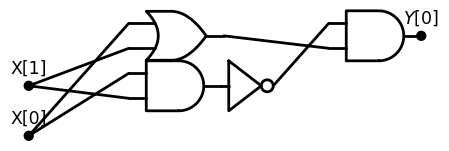

In [107]:
circuit(xor)

__Q__ Give a circuit/program for computing $XOR_n:\{0,1\}^n \rightarrow \{0,1\}$ such that $XOR(x) = \sum_{i=0}^{n-1} x_i (\mod 2)$?

In [112]:
def xor3(a,b,c): return xor(a,xor(b,c))
table(xor3)
def xor4(a,b,c,d): return xor(a,xor3(b,c,d))
table(xor4)

x        | xor4(x) 
---------|---------
0000     | 0       
0001     | 1       
0010     | 1       
0011     | 0       
0100     | 1       
0101     | 0       
0110     | 0       
0111     | 1       
1000     | 1       
1001     | 0       
1010     | 0       
1011     | 1       
1100     | 0       
1101     | 1       
1110     | 1       
1111     | 0       


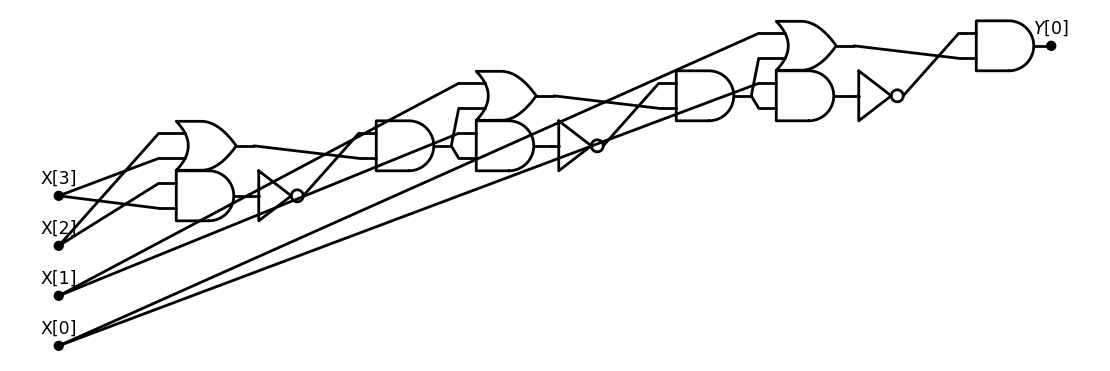

In [113]:
circuit(xor4)

Back to powerpoint

....

__Q:__ Write NAND-CIRC code to compute $XOR:\{0,1\}^2 \rightarrow \{0,1\}$ such that $XOR(a,b) = a+b \mod 2$.

Reminder AON-CIRC code is:
```python
t1      = AND(X[0],X[1])
nott1   = NOT(t1)
t2      = OR(X[0],X[1])
Y[0]    = AND(nott1,t2)
```

In [ ]:
def parseline(line):
    variable_name, operation = line.split('=')
    op_name, args = operation.split('(')
    arg1, *rest = args.strip(')').split(',')
    arg2 = rest[0].strip() if rest else ''
    return [variable_name.strip(), op_name.strip(), arg1.strip(), arg2]

In [114]:
def AON2NAND(code):
    output = ""; counter = 0
    for line in code.split("\n"):
        if not line: continue
        foo,op,bar,blah = parseline(line) 
        # helper: parses "foo = op(bar,blah)"
        if op=="NOT":
            output += f"{foo} = NAND({bar},{bar})\n"
        if op=="AND": 
            output += f"temp_{counter} = NAND({bar},{blah})\n"
            output += f"{foo} = NAND(temp_{counter},temp_{counter})\n"
            counter +=1
        if op=="OR":
            output += f"temp_{counter} = NAND({bar},{bar})\n"
            output += f"temp_{counter+1} = NAND({blah},{blah})\n"
            output += f"{foo} = NAND(temp_{counter},temp_{counter+1})\n"
            counter +=2
    return output

temp_0 = NAND(X[0],X[1])
t1 = NAND(temp_0,temp_0)
nott1 = NAND(t1,t1)
temp_1 = NAND(X[0],X[0])
temp_2 = NAND(X[1],X[1])
t2 = NAND(temp_1,temp_2)
temp_3 = NAND(nott1,t2)
Y[0] = NAND(temp_3,temp_3)



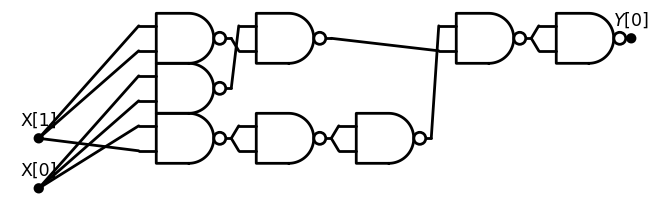

In [115]:
xornand = AON2NAND(xorcode)
print(xornand)
circuit(FUNC(xornand))

In [ ]:
# Q: what does this program compute?
mystery='''
u = NAND(X[0],X[1])
v = NAND(X[0],u)
w = NAND(X[1],u) 
Y[0] = NAND(v,w)'''

In [ ]:
m = FUNC(mystery)
circuit(m)

In [ ]:
table(m)

__Q:__ Design a NAND circuit to compute $XOR4:\{0,1\}^4 \rightarrow \{0,1\}$ where $XOR4(a,b,c,d) = a+b+c+d \mod 2$

In [ ]:
def XOR2(a,b):
    u = NAND(a,b)
    v = NAND(a,u)
    w = NAND(b,u)
    return NAND(v,w)

def XOR4(a,b,c,d):
    u = XOR2(a,b)
    v = XOR2(c,d)
    return XOR2(u,v)

XOR4circ = circuit(XOR4)

In [ ]:
table(XOR4)

In [ ]:
print(AON(XOR4))

## Next Up:

__Theorem:__ For _every_ function $f:\{0,1\}^n \rightarrow \{0,1\}^m$ there exists a Boolean circuit to compute $f$.

__Corollary:__ For every such $f$, there is AON-CIRC program/NAND circuit/NAND-CIRC program to compute $f$.